In [63]:
import pandapower as pp
import pandapower.networks as nw
import pandapower.plotting as plot
import matplotlib.pyplot as plt
import math
import numpy as np
import copy
#from pandapower.plotting import simple_plot, simple_plotly, pf_res_plotly

# Predefined network of IEEE 4gs bus system 
net = pp.networks.case4gs()
#plot.simple_plot(net)

In [64]:
####Shunt FACTS device (bus 1)
#MV bus
bus_SVC = pp.create_bus(net, name='MV SVCtrafo bus', vn_kv=69, type='n', geodata=(-2,2.5), zone=2, max_vm_pu=1.1,
                        min_vm_pu=0.9)
#Trafo
trafoSVC = pp.create_transformer_from_parameters(net, hv_bus=1, lv_bus=4, in_service=True, 
                                                name='trafoSVC', sn_mva=110, vn_hv_kv=230 , vn_lv_kv=69, 
                                                vk_percent=12, vkr_percent=0.26, pfe_kw=55, i0_percent=0.06,
                                                shift_degree=0, tap_side='hv', tap_neutral=0, tap_min=-9, tap_max=9,
                                                tap_step_percent=1.5, tap_step_degree=0, tap_phase_shifter=False) 
#Breaker between grid HV bus and trafo HV bus to connect buses
sw_SVC = pp.create_switch(net, bus=1, element=0, et='t', type='CB', closed=False)
#Shunt devices connected with MV bus
shuntDev = pp.create_shunt(net, bus_SVC, 0, in_service=True, name='Shunt Device', step = 1)

In [65]:
####Series device (at line 3, in middle between bus 2 and 3)
#Add intermediate buses for bypass and series compensation impedance
bus_SC1 = pp.create_bus(net, name='SC bus 1', vn_kv=230, type='n', geodata=(-1,3.1), zone=2, max_vm_pu=1.1, min_vm_pu=0.9)
bus_SC2 = pp.create_bus(net, name='SC bus 2', vn_kv=230, type='n', geodata=(-1,3.0), zone=2, max_vm_pu=1.1, min_vm_pu=0.9)
sw_SC_bypass = pp.create_switch(net, bus=5, element=6, et='b', type='CB', closed=True)
imp_SC = pp.create_impedance(net, from_bus=5, to_bus=6, rft_pu=0.000001272, xft_pu=-0.0636,
                             rtf_pu=0.000001272, xtf_pu=-0.0636, sn_mva=250, in_service=True) #Just some default values
#Adjust orginal Line 3 to connect to new buses instead.
net.line.at[3, ['length_km', 'to_bus', 'name']] = [0.5, 5, 'line1_SC']                        
lineSC2 = pp.create_line_from_parameters(net, name='line2_SC', c_nf_per_km=net.line.at[3,'c_nf_per_km'],
                       df=net.line.at[3, 'df'], from_bus=6, g_us_per_km=net.line.at[3, 'g_us_per_km'],
                       in_service=net.line.at[3, 'in_service'], length_km=0.5, max_i_ka=net.line.at[3, 'max_i_ka'],
                       max_loading_percent=net.line.at[3, 'max_loading_percent'], parallel=net.line.at[3, 'parallel'],
                       r_ohm_per_km=net.line.at[3, 'r_ohm_per_km'], std_type=net.line.at[3, 'std_type'], to_bus=3, 
                       type=net.line.at[3, 'type'], x_ohm_per_km=net.line.at[3, 'x_ohm_per_km'])

In [66]:
###EXCHANGE PV GEN INTO SGEN
pp.runpp(net)
net.gen.drop(index=[0], inplace= True) #Drop PV generator
sgen_nom_p_mw = net.res_gen.p_mw # Set generator nominal output as output of generator during IEEE nominal setup
sgen_nom_q_mvar = net.res_gen.q_mvar
sgen = pp.create_sgen(net, 3, p_mw=sgen_nom_p_mw, q_mvar=sgen_nom_q_mvar, name='static generator', scaling=1)

In [67]:
##Function for nose curve
def NoseCurve(p_low_pu, p_high_pu, bus_index, net):
    
    network = copy.deepcopy(net) #So not changing anything in actual network
    fig = plt.figure()
    
    l_arr = np.linspace(p_low_pu, p_high_pu, 50)
    l_len = len(l_arr)
    v_res = np.zeros(l_len)
    l_ind = bus_index
    
    for ind in range(l_len):
        # Load scaling
        l_scaling = l_arr[ind]
        l_p_mw = network.load.p_mw[l_ind]
        l_q_mvar = network.load.q_mvar[l_ind]
        network.load.p_mw[l_ind] = l_p_mw*l_scaling
        network.load.q_mvar[l_ind] = l_q_mvar*l_scaling
        pp.runpp(network)
        v_res[ind] = network.res_bus.vm_pu[l_ind]

    plt.plot(l_arr, v_res, figure=fig)
    plt.ylabel('Bus Voltage [pu]')
    plt.xlabel('Active power [pu]')
    
    return fig

In [68]:
##Function for transition from reference power to reactance of "TCSC"
def K_x_comp_pu(net, x_line_pu, p_ref_pu):
    v_s_pu = net.res_bus.vm_pu[3]
    v_r_pu = net.res_bus.vm_pu[2]
    delta_deg = net.res_bus.va_degree[3] - net.res_bus.va_degree[2]
    k_x_comp = ((v_s_pu * v_r_pu * math.sin(math.radians(delta_deg))) / (p_ref_pu* x_line_ohm)) - 1  
    return k_x_comp

p_ref_pu = 1
S_base = 100e6
V_base = 230e3
x_base = pow(V_base,2) / S_base
x_line_ohm = net.line.x_ohm_per_km[3]
x_line_pu = x_line_ohm / x_base # Can take one since this line is divivded into 
                                              # 2 identical lines with length 0.5 km  
k_x_comp_pu = K_x_comp_pu(net, x_line_pu, p_ref_pu)
print([v_s_pu, v_r_pu, x_line_ohm, delta_deg, p_ref_pu])
print(k_x_comp_pu)

[1.0199999999999998, 0.9690305913652232, 33.6444, 3.3930762132651475, 1]
-0.998261230652856


In [69]:
## Function for transition from reference parameter to reactive power output of shunt device

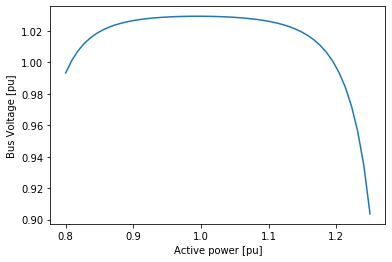

In [70]:
NoseCurve1 = NoseCurve(0.8,1.25,1, net)

In [71]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-136.806814,-83.441420
1,0.982421,-0.977077,170.000000,105.350000
2,0.969031,-1.871668,200.000000,123.940000
3,1.020000,1.521408,-238.000000,-131.904101
4,NaN,NaN,0.000000,0.000000
5,0.995088,-0.143270,0.000000,0.000000
6,0.995088,-0.143270,0.000000,0.000000


In [72]:
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,38.722798,22.292370,-38.495881,-31.229183,0.226918,-8.936813,0.112159,0.126658,0.126658,1.000000,0.000000,0.982421,-0.977077,20.182829
1,98.084015,61.149050,-97.053680,-63.511074,1.030336,-2.362024,0.290141,0.300459,0.300459,1.000000,0.000000,0.969031,-1.871668,47.877698
2,-131.504119,-74.120817,133.219044,74.923927,1.714924,0.803110,0.385709,0.376146,0.385709,0.982421,-0.977077,1.020000,1.521408,61.462187
3,-102.946320,-60.428926,103.887554,58.985702,0.941234,-1.443224,0.309226,0.301364,0.309226,0.969031,-1.871668,0.995088,-0.143270,49.274683
4,-103.887554,-58.985702,104.780956,56.980174,0.893402,-2.005529,0.301364,0.293528,0.301364,0.995088,-0.143270,1.020000,1.521408,48.021956


In [73]:
# Enabling shunt device, true means enabled
net.switch.closed[0] = False
net.trafo.tap_pos[0] = 0

In [74]:
# Enabling the series compensation, False means enabled
net.switch.at[1, 'closed'] = False
net.impedance.loc[0, ['xft_pu','xtf_pu']] = x_line_pu * k_x_comp_pu
pp.runpp(net)
net.res_load
net.load

,bus,const_i_percent,const_z_percent,controllable,in_service,name,p_mw,q_mvar,scaling,sn_mva,type
0,0,0.0,0.0,False,True,None,50.0,30.99,1.0,NaN,None
1,1,0.0,0.0,False,True,None,170.0,105.35,1.0,NaN,None
2,2,0.0,0.0,False,True,None,200.0,123.94,1.0,NaN,None
3,3,0.0,0.0,False,True,None,80.0,49.58,1.0,NaN,None


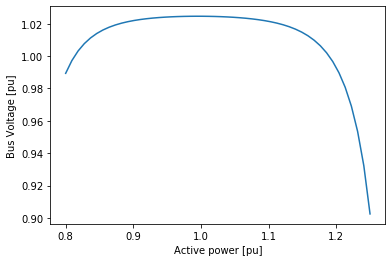

In [75]:
NoseCurve2 = NoseCurve(0.8,1.25,1, net)

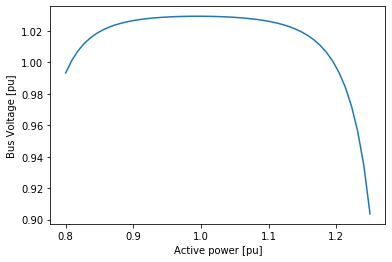

In [76]:
NoseCurve1

In [77]:
########Some Settings

In [78]:
# Generation scaling
g_scaling = 1
g_ind = 0
g_p_mw = net.sgen.p_mw[g_ind]
g_q_mvar = net.sgen.q_mvar[g_ind]
net.sgen.p_mw[g_ind] = g_p_mw*g_scaling
net.sgen.q_mvar[g_ind] = g_q_mvar*g_scaling